# Sistemas de Información Gerencial
# Algoritmo k-means

**Autores:** Arroyo, A. & Espinoza, P. & Bayona, E. & Lino, E. & Mendoza, J.

Importación de librerías

In [1]:
import psycopg2
import psycopg2.extras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from config import config

Conexión con la BDD PostgreSQL mediante librería psycopg2 y obtención de data

In [2]:
conn = None
try:
    # parámetros de conexión con la función config importada de config.py
    params = config()
    # conexión
    conn = psycopg2.connect(**params)
    # sentencia para obtener todas las filas y columnas de la tabla gye_ecuador
    sql = "SELECT * FROM gye_ecuador1 ORDER BY id"
    # obtención de la data y conversión a tipo dataframe
    coords = pd.read_sql_query(sql, conn)
except (Exception, psycopg2.DatabaseError) as error:
    print(error)
finally:
    if conn is not None:
        conn.close()
coords

,id,latitud,longitud,usuario,velocidad,id_trayectoria,tiempo,transporte,geom
0,1,40.831052,-1.086649,alexortizzzzzz@gmail.com,NaN,20,NaN,Vehiculo particular,0101000020E61000009AB2D30FEA62F1BF40A374E95F6A...
1,2,40.831911,-1.087223,alexortizzzzzz@gmail.com,NaN,20,NaN,Vehiculo particular,0101000020E61000001958C7F14365F1BF6117450F7C6A...
2,3,40.832187,-1.087341,alexortizzzzzz@gmail.com,NaN,20,NaN,Vehiculo particular,0101000020E6100000569929ADBF65F1BF0394861A856A...
3,4,40.832496,-1.087512,alexortizzzzzz@gmail.com,NaN,20,NaN,Vehiculo particular,0101000020E6100000EF1EA0FB7266F1BF81069B3A8F6A...
4,5,40.832804,-1.087791,alexortizzzzzz@gmail.com,NaN,20,NaN,Vehiculo particular,0101000020E610000053211E899767F1BF2FFD4B52996A...
...,...,...,...,...,...,...,...,...,...
51832,51833,-2.136522,-79.884370,gary.reyesz@ug.edu.ec,0.0,435,1.509979e+12,Metrovia,0101000020E61000000D701A8699F853C0E789219E9817...
51833,51834,-2.136522,-79.884370,gary.reyesz@ug.edu.ec,0.0,435,1.509979e+12,Metrovia,0101000020E61000000D701A8699F853C0E789219E9817...
51834,51835,-2.136522,-79.884370,gary.reyesz@ug.edu.ec,0.0,435,1.509979e+12,Metrovia,0101000020E61000000D701A8699F853C0E789219E9817...
51835,51836,-2.136522,-79.884370,gary.reyesz@ug.edu.ec,0.0,435,1.509979e+12,Metrovia,0101000020E61000000D701A8699F853C0E789219E9817...


Ver tipo de datos de las columnas

In [3]:
coords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51837 entries, 0 to 51836
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              51837 non-null  int64  
 1   latitud         51837 non-null  float64
 2   longitud        51837 non-null  float64
 3   usuario         51837 non-null  object 
 4   velocidad       49342 non-null  float64
 5   id_trayectoria  51837 non-null  int64  
 6   tiempo          50401 non-null  float64
 7   transporte      51651 non-null  object 
 8   geom            51837 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 3.6+ MB


Visualización de primeras filas del dataframe

In [4]:
coords.head()

,id,latitud,longitud,usuario,velocidad,id_trayectoria,tiempo,transporte,geom
0,1,40.831052,-1.086649,alexortizzzzzz@gmail.com,NaN,20,NaN,Vehiculo particular,0101000020E61000009AB2D30FEA62F1BF40A374E95F6A...
1,2,40.831911,-1.087223,alexortizzzzzz@gmail.com,NaN,20,NaN,Vehiculo particular,0101000020E61000001958C7F14365F1BF6117450F7C6A...
2,3,40.832187,-1.087341,alexortizzzzzz@gmail.com,NaN,20,NaN,Vehiculo particular,0101000020E6100000569929ADBF65F1BF0394861A856A...
3,4,40.832496,-1.087512,alexortizzzzzz@gmail.com,NaN,20,NaN,Vehiculo particular,0101000020E6100000EF1EA0FB7266F1BF81069B3A8F6A...
4,5,40.832804,-1.087791,alexortizzzzzz@gmail.com,NaN,20,NaN,Vehiculo particular,0101000020E610000053211E899767F1BF2FFD4B52996A...


Se eliminan las columnas que no interesan, como id, usuario, entre otros, debido a que la agrupación de k-means se hace con tipos de datos numéricos

In [5]:
coords_vars = coords.drop(['id', 'usuario', 'transporte', 'geom', "id_trayectoria"], axis=1)

# debido a que la data obtenida de la base de datos tiene valores no válidos como 0 o NaN (Not a Number) hay que modificarla
# se reemplazan los 0 con NaN
coords_vars['velocidad'] = coords_vars['velocidad'].replace(0, np.NaN)
coords_vars['tiempo'] = coords_vars['tiempo'].replace(0, np.NaN)

# a aquellos NaN se los reemplaza con la media de los demás valores que sí son válidos
velocidadMean = np.nanmean(coords_vars['velocidad'])
coords_vars['velocidad'] = coords_vars['velocidad'].fillna(velocidadMean)
tiempoMean = np.nanmean(coords_vars['tiempo'])
coords_vars['tiempo'] = coords_vars['tiempo'].fillna(tiempoMean)

coords_vars

,latitud,longitud,velocidad,tiempo
0,40.831052,-1.086649,21.666206,1.483942e+12
1,40.831911,-1.087223,21.666206,1.483942e+12
2,40.832187,-1.087341,21.666206,1.483942e+12
3,40.832496,-1.087512,21.666206,1.483942e+12
4,40.832804,-1.087791,21.666206,1.483942e+12
...,...,...,...,...
51832,-2.136522,-79.884370,21.666206,1.509979e+12
51833,-2.136522,-79.884370,21.666206,1.509979e+12
51834,-2.136522,-79.884370,21.666206,1.509979e+12
51835,-2.136522,-79.884370,21.666206,1.509979e+12


Ahora todos las columnas tienen un tipo de dato similar. Ahora es posible la agrupación de individuos

In [6]:
coords_vars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51837 entries, 0 to 51836
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitud    51837 non-null  float64
 1   longitud   51837 non-null  float64
 2   velocidad  51837 non-null  float64
 3   tiempo     51837 non-null  float64
dtypes: float64(4)
memory usage: 1.6 MB


Se obtienen estadísticos descriptivos. Se puede notar una variación radical de valores, es necesario normalizar

In [7]:
coords_vars.describe()

,latitud,longitud,velocidad,tiempo
count,51837.000000,51837.000000,5.183700e+04,5.183700e+04
mean,-7.369167,-73.952816,2.166621e+01,1.483942e+12
std,14.595880,14.039984,1.835731e+01,1.858899e+11
min,-34.932339,-79.967782,8.738869e-12,3.329112e+06
25%,-2.196569,-79.893406,4.314699e+00,1.508265e+12
50%,-2.184716,-79.882844,2.166621e+01,1.509229e+12
75%,-2.159023,-79.877669,2.772037e+01,1.509230e+12
max,40.880240,-1.086649,1.764367e+02,2.727450e+12


## Normalización de los datos
Se normalizan los valores mediante una simple fórmula, obteniendo así valores entre 0 y 1 en todos los individuos

In [8]:
coords_norm = (coords_vars - coords_vars.min())/(coords_vars.max() - coords_vars.min())

Estadísticos descriptivos con valores normalizados

In [9]:
coords_norm.describe()

,latitud,longitud,velocidad,tiempo
count,51837.000000,51837.000000,51837.000000,51837.000000
mean,0.363570,0.076254,0.122799,0.544076
std,0.192526,0.177989,0.104045,0.068155
min,0.000000,0.000000,0.000000,0.000000
25%,0.431799,0.000943,0.024455,0.552994
50%,0.431955,0.001077,0.122799,0.553347
75%,0.432294,0.001142,0.157112,0.553348
max,1.000000,1.000000,1.000000,1.000000


## Búsqueda de cantidad óptima de clusters
Al desconocer el número de cluster requeridos, se pone un valor arbitrario de 10 y 300 iteraciones para dar con una buena cantidad de clusters para los datos.

In [10]:
wcss = []

# range(1, n-1) siendo n el numero de clusters deseados
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, max_iter=300)
    kmeans.fit(coords_norm) # se aplica k-means
    wcss.append(kmeans.inertia_)        

WCSS (Within-Cluster Sum of Squares) o suma de cuadrados dentro del conglomerado

Gráfica de resultados de WCSS para formar el codo de Jambú

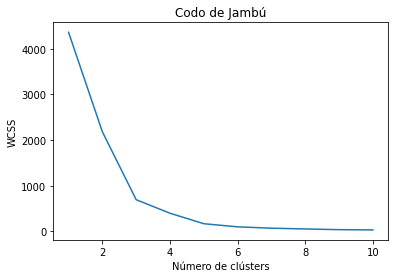

In [11]:
plt.plot(range(1, 11), wcss)
plt.title('Codo de Jambú')
plt.xlabel('Número de clústers')
plt.ylabel('WCSS') # WCSS es un indicador de qué tan similares son los individuos dentro de los clusters
plt.show()

El codo de Jambú nos indica la razón de
 la similitud entre individuos y el número de clusters

Se elige el punto donde la gráfica deja de disminuir significativamente, en este caso fueron 3 clusters

## Aplicación de método k-means
La función "KMeans(n_clusters, max_iter)" y su método "fit(data)" se encarga de la lógica del algoritmo k-means, siendo la idea principal: ¿qué tan similares son los individuos dentro del cluster?

In [12]:
clustering = KMeans(n_clusters=3, max_iter=300) # crea el modelo
clustering.fit(coords_norm) # aplica el modelo a la base de datos

KMeans(n_clusters=3)

## Agregando clasificación a la data original

In [13]:
coords['KMeans_Clusters'] = clustering.labels_ # los resultos del clustering se guardan en labels_ dentro del modelo
coords.head()

,id,latitud,longitud,usuario,velocidad,id_trayectoria,tiempo,transporte,geom,KMeans_Clusters
0,1,40.831052,-1.086649,alexortizzzzzz@gmail.com,NaN,20,NaN,Vehiculo particular,0101000020E61000009AB2D30FEA62F1BF40A374E95F6A...,2
1,2,40.831911,-1.087223,alexortizzzzzz@gmail.com,NaN,20,NaN,Vehiculo particular,0101000020E61000001958C7F14365F1BF6117450F7C6A...,2
2,3,40.832187,-1.087341,alexortizzzzzz@gmail.com,NaN,20,NaN,Vehiculo particular,0101000020E6100000569929ADBF65F1BF0394861A856A...,2
3,4,40.832496,-1.087512,alexortizzzzzz@gmail.com,NaN,20,NaN,Vehiculo particular,0101000020E6100000EF1EA0FB7266F1BF81069B3A8F6A...,2
4,5,40.832804,-1.087791,alexortizzzzzz@gmail.com,NaN,20,NaN,Vehiculo particular,0101000020E610000053211E899767F1BF2FFD4B52996A...,2


## Visualización de clusters formados
Se aplica el análisis de componentes principales para darnos una idea de como se formaron los clusters

Básicamente se aplican componentes principales porque la data original tiene varias columnas (componentes), y para ser presentada en un plano bidimensional es necesario dos componentes

En este sentido, se obtienen dos componentes que representan todas las columnas de la data

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_coords = pca.fit_transform(coords_norm)
pca_coords_df = pd.DataFrame(data=pca_coords, columns=['Componente_1', 'Componente_2'])
pca_coords_names = pd.concat([pca_coords_df, coords[['KMeans_Clusters']]], axis=1)

pca_coords_names

,Componente_1,Componente_2,KMeans_Clusters
0,-0.062030,1.119438,2
1,-0.062043,1.119438,2
2,-0.062047,1.119438,2
3,-0.062051,1.119439,2
4,-0.062057,1.119438,2
...,...,...,...
51832,-0.094009,-0.028271,1
51833,-0.094009,-0.028271,1
51834,-0.094009,-0.028271,1
51835,-0.094009,-0.028271,1


Usando la librería matplotlib.pyplot (plt) se grafican los resultados

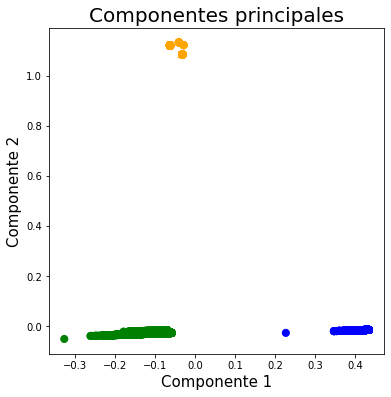

In [15]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Componente 1', fontsize=15)
ax.set_ylabel('Componente 2', fontsize=15)
ax.set_title('Componentes principales', fontsize=20)

color_theme = np.array(['blue', 'green', 'orange'])
ax.scatter(x=pca_coords_names.Componente_1, y=pca_coords_names.Componente_2,
           c=color_theme[pca_coords_names.KMeans_Clusters], s=50)
plt.show()